/var/folders/4f/wdty282j51ddljklq5t8rkc00000gn/T/ipykernel_59855/720274844.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/kushalsathyanarayan/Desktop/projects/AIML/stock-market-prediction/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Columns in the downloaded data: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

Shape of data after selecting 'Close' column: (2651, 1)
Data head after selection:
                 Close
Date                 
2015-01-02  24.288584
2015-01-05  23.604330
2015-01-06  23.606564
2015-01-07  23.937578
2015-01-08  24.857306

Building and training the LSTM model...
2061/2061 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0015
Model training complete.

Making predictions on validation data...
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

--- Select Prediction Timeframe ---
1. Tomorrow (1 day)
2. Next 6 days
3. Next 30 days

Predicting stock prices for the next 1 day(s)...

Generating plot...


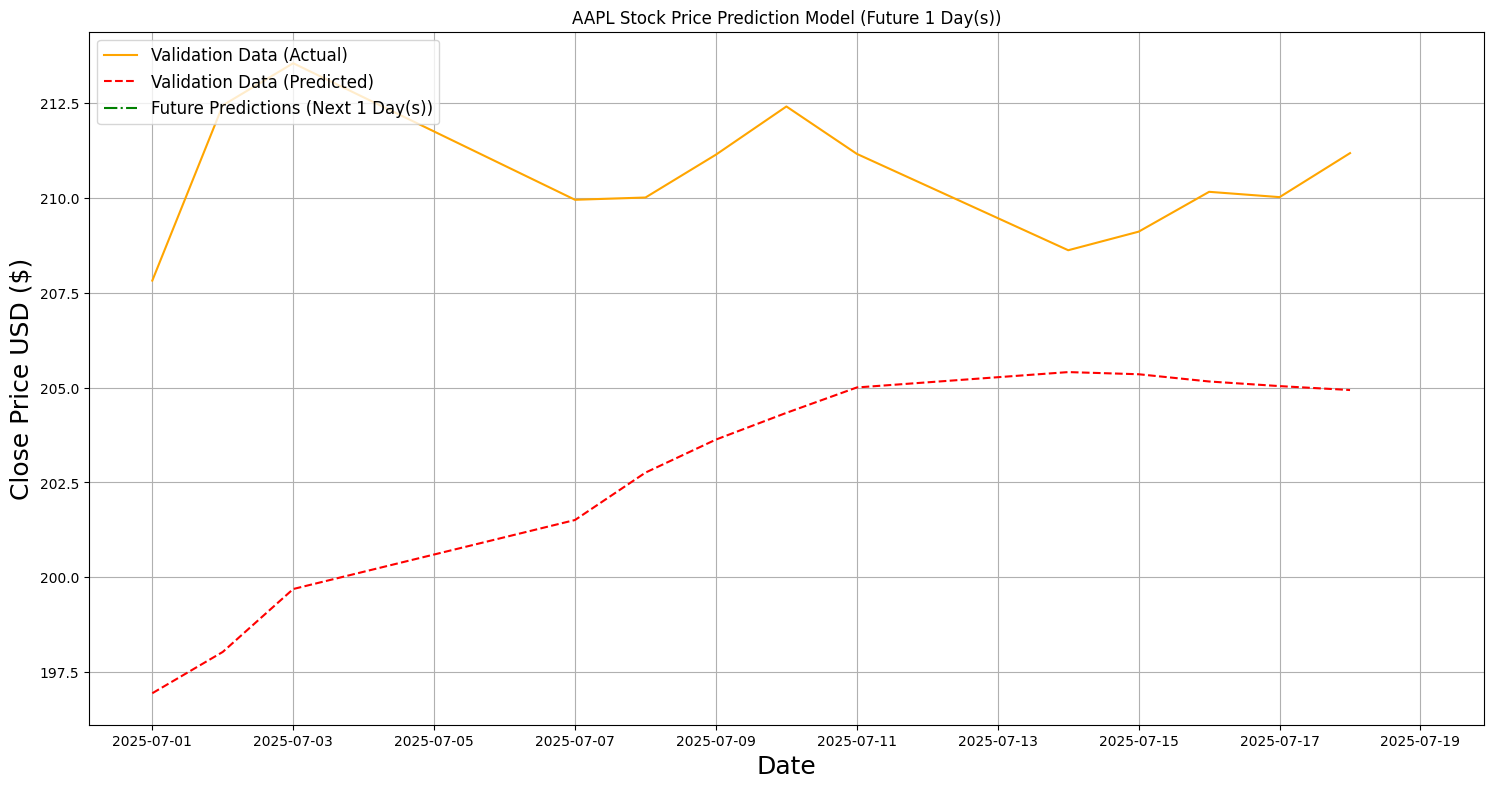


Prediction and plotting complete!

Important Note: Stock market prediction is inherently difficult and these models are for educational purposes. Future predictions become less reliable the further out they go.


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

ticker_symbol = input("Enter the stock ticker symbol (e.g., AAPL, GOOGL, MSFT): ").upper()

start_date = '2015-01-01'
end_date = dt.datetime.now()

print(f"\nDownloading historical data for {ticker_symbol} from {start_date} to {end_date.strftime('%Y-%m-%d')}...")

try:
    data = yf.download(ticker_symbol, start=start_date, end=end_date)

    if data.empty:
        print(f"Error: No data found for ticker symbol '{ticker_symbol}' or date range. Please check the ticker and try again.")
        exit()

    print("\nColumns in the downloaded data:", data.columns)

    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs('Close', level='Price', axis=1)
        data.columns = ['Close']
    else:
        if 'Close' in data.columns:
            data = data[['Close']]
        elif 'Adj Close' in data.columns:
            data = data[['Adj Close']]
            data = data.rename(columns={'Adj Close': 'Close'})
        else:
            print(f"Error: Neither 'Close' nor 'Adj Close' column found in data for {ticker_symbol}.")
            exit()


except Exception as e:
    print(f"An error occurred during data download or initial processing: {e}")
    exit()

print("\nShape of data after selecting 'Close' column:", data.shape)
print("Data head after selection:\n", data.head())

dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len = int(np.ceil(len(scaled_data) * .8))
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

prediction_days = 60
for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i-prediction_days:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print("\nBuilding and training the LSTM model...")
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)
print("Model training complete.")

print("\nMaking predictions on validation data...")

test_data = scaled_data[training_data_len - prediction_days:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions_validation = model.predict(x_test)
predictions_validation = scaler.inverse_transform(predictions_validation)

print("\n--- Select Prediction Timeframe ---")
print("1. Tomorrow (1 day)")
print("2. Next 6 days")
print("3. Next 30 days")
timeframe_choice = input("Enter your choice (1, 2, or 3): ")

num_future_days = 0
if timeframe_choice == '1':
    num_future_days = 1
elif timeframe_choice == '2':
    num_future_days = 6
elif timeframe_choice == '3':
    num_future_days = 30
else:
    print("Invalid choice. Defaulting to predicting tomorrow (1 day).")
    num_future_days = 1

print(f"\nPredicting stock prices for the next {num_future_days} day(s)...")

last_60_days = scaled_data[len(scaled_data) - prediction_days:].reshape(1, prediction_days, 1)

future_predictions = []
current_prediction_sequence = last_60_days

for _ in range(num_future_days):
    next_day_scaled_prediction = model.predict(current_prediction_sequence, verbose=0)
    
    next_day_price = scaler.inverse_transform(next_day_scaled_prediction)[0][0]
    future_predictions.append(next_day_price)
    
    current_prediction_sequence = np.append(current_prediction_sequence[:, 1:, :], next_day_scaled_prediction.reshape(1, 1, 1), axis=1)

last_known_date = data.index[-1]
future_dates = [last_known_date + dt.timedelta(days=i) for i in range(1, num_future_days + 1)]

print("\nGenerating plot...")

train = data.iloc[:training_data_len].copy()
valid = data.iloc[training_data_len:].copy()

valid.loc[:, 'Predictions_Validation'] = predictions_validation

future_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Future_Predictions'])

if num_future_days == 1 or num_future_days == 6:
    plot_start_date = last_known_date.replace(day=1)
    
    plot_train = train[train.index >= plot_start_date]
    plot_valid = valid[valid.index >= plot_start_date]
    
    if plot_train.empty and not plot_valid.empty:
        pass
    
    if plot_train.empty and plot_valid.empty:
        print("Warning: Not enough recent data for focused plot (current month). Plotting full history.")
        plot_train = train
        plot_valid = valid
else:
    plot_train = train
    plot_valid = valid

plt.figure(figsize=(18, 9))
plt.title(f'{ticker_symbol} Stock Price Prediction Model (Future {num_future_days} Day(s))')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

if not plot_train.empty:
    plt.plot(plot_train['Close'], label='Train Data (Actual)', color='blue')

if not plot_valid.empty:
    plt.plot(plot_valid['Close'], label='Validation Data (Actual)', color='orange')
    plt.plot(plot_valid['Predictions_Validation'], label='Validation Data (Predicted)', color='red', linestyle='--')

plt.plot(future_df['Future_Predictions'], label=f'Future Predictions (Next {num_future_days} Day(s))', color='green', linestyle='-.')

plt.legend(loc='upper left', fontsize=12)
plt.grid(True)
plt.show()

print("\nPrediction and plotting complete!")
print("\nImportant Note: Stock market prediction is inherently difficult and these models are for educational purposes. Future predictions become less reliable the further out they go.")
